Adding edges from source:
Edge from (-5, -1, 1) to [1. 1. 1.] intersects with dodecahedron edge ((0.0, 0.6180339887498948, 1.618033988749895), (-1.0, 1.0, 1.0))
Added edge from (-5, -1, 1) to [-1.  1.  1.]
Added edge from (-5, -1, 1) to [ 1. -1.  1.]
Added edge from (-5, -1, 1) to [-1. -1.  1.]
Edge from (-5, -1, 1) to [ 1.  1. -1.] intersects with dodecahedron edge ((0.0, 0.6180339887498948, 1.618033988749895), (-1.0, 1.0, 1.0))
Added edge from (-5, -1, 1) to [-1.  1. -1.]
Added edge from (-5, -1, 1) to [ 1. -1. -1.]
Added edge from (-5, -1, 1) to [-1. -1. -1.]
Edge from (-5, -1, 1) to [0.         0.61803399 1.61803399] intersects with dodecahedron edge ((-1.0, 1.0, 1.0), (-1.618033988749895, 0.0, 0.6180339887498948))
Edge from (-5, -1, 1) to [ 0.         -0.61803399  1.61803399] intersects with dodecahedron edge ((-1.618033988749895, 0.0, 0.6180339887498948), (-1.0, -1.0, 1.0))
Edge from (-5, -1, 1) to [ 0.          0.61803399 -1.61803399] intersects with dodecahedron edge ((-1.0, 1.

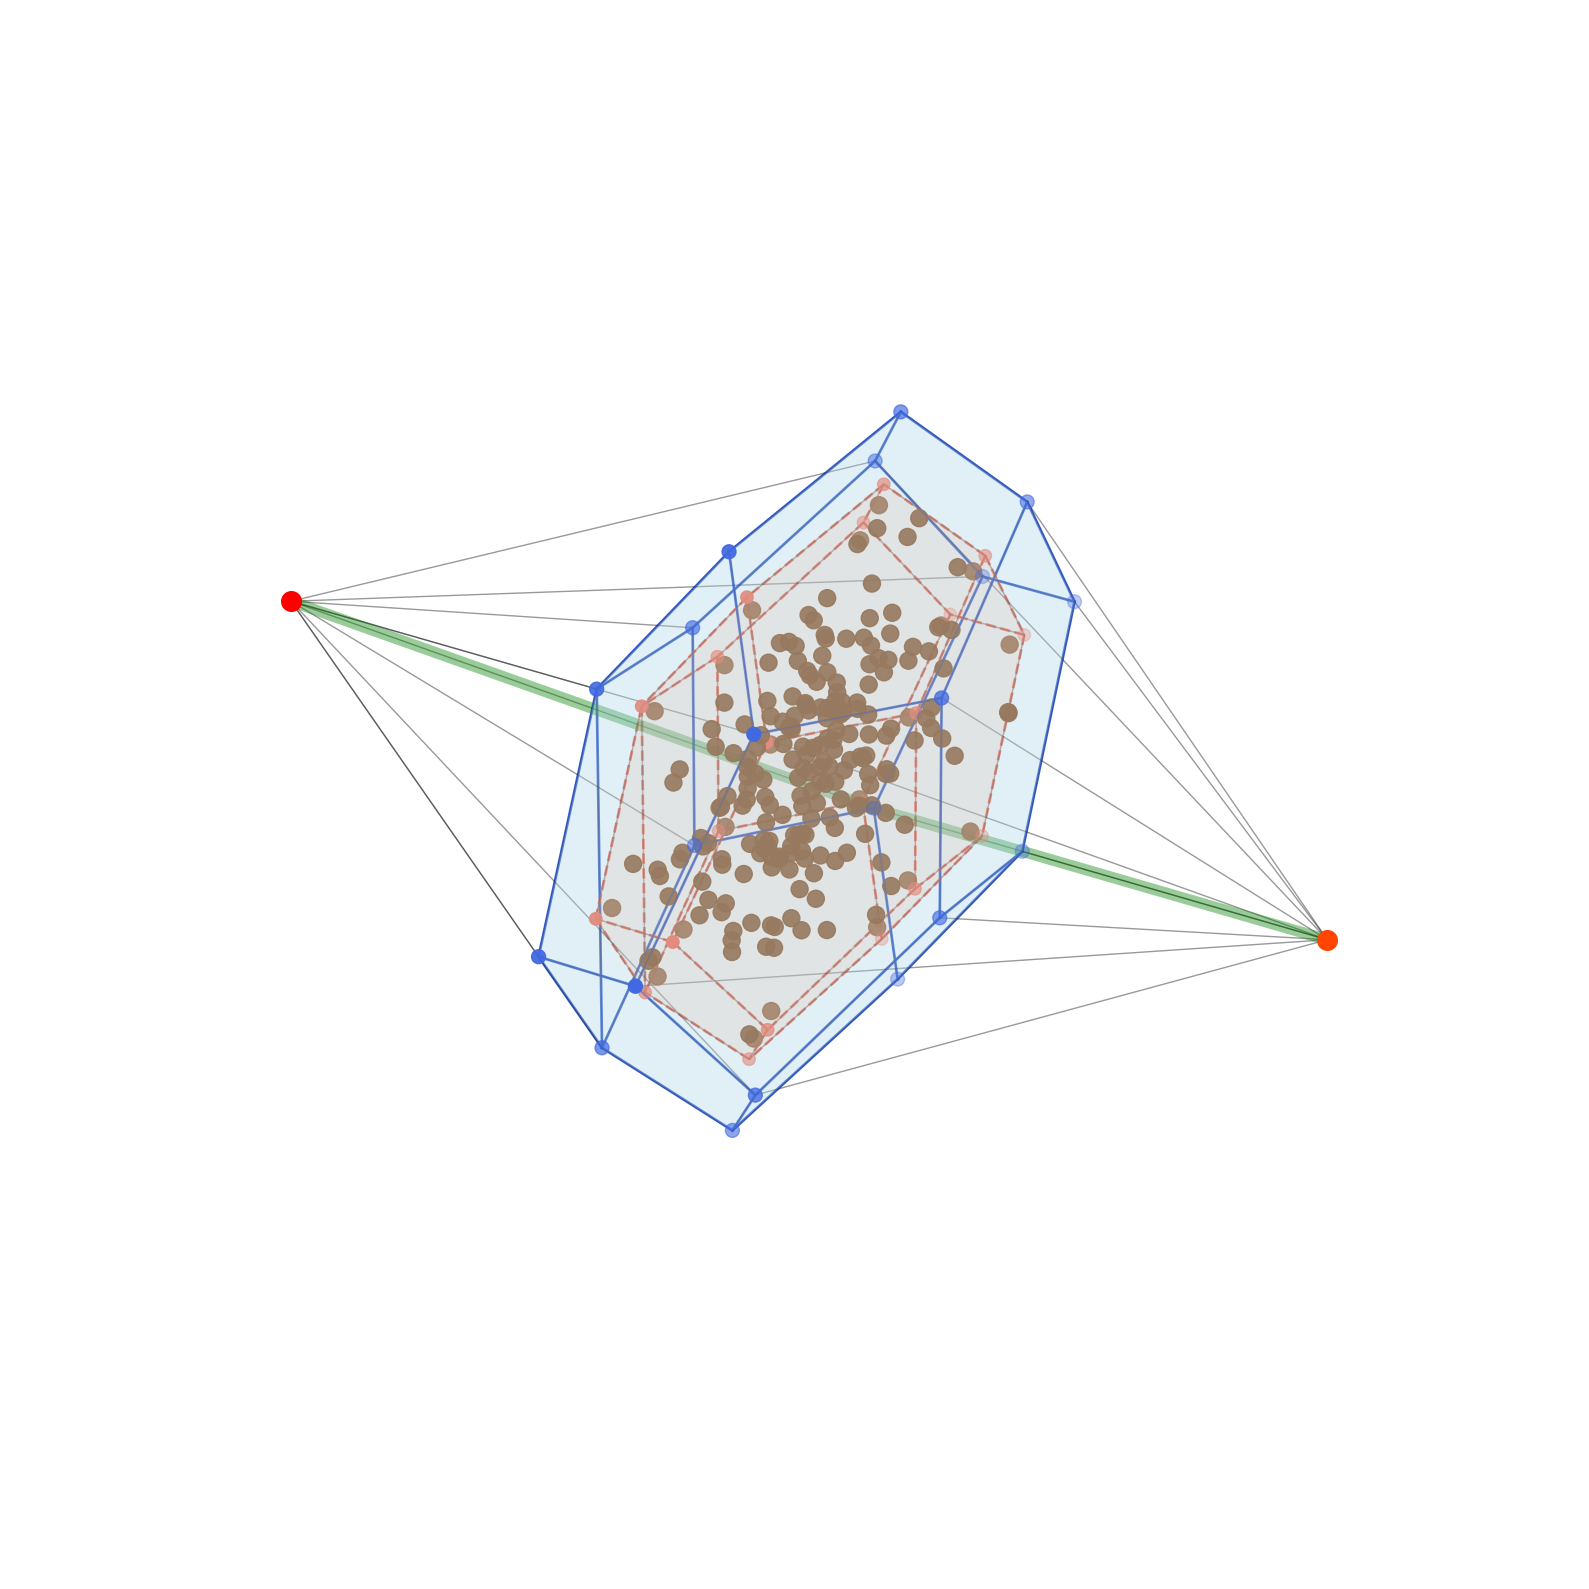

In [4]:
import networkx as nx
from shapely.geometry import LineString
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Define the golden ratio
phi = (1 + np.sqrt(5)) / 2

# Define the vertices of the outer dodecahedron
vertices_outer = np.array([
    [1, 1, 1], [-1, 1, 1], [1, -1, 1], [-1, -1, 1],
    [1, 1, -1], [-1, 1, -1], [1, -1, -1], [-1, -1, -1],
    [0, 1/phi, phi], [0, -1/phi, phi], [0, 1/phi, -phi], [0, -1/phi, -phi],
    [1/phi, phi, 0], [-1/phi, phi, 0], [1/phi, -phi, 0], [-1/phi, -phi, 0],
    [phi, 0, 1/phi], [-phi, 0, 1/phi], [phi, 0, -1/phi], [-phi, 0, -1/phi]
])

# Calculate the center of the outer dodecahedron
center = np.mean(vertices_outer, axis=0)

# Create the inner dodecahedron by scaling and translating the outer one
scale_factor = 0.8  # This will create a 0.2 distance between the dodecahedrons
vertices_inner = (vertices_outer - center) * scale_factor + center

# Define the edges
edges = [
    (0, 16), (0, 8), (0, 12), (16, 2), (16, 18), (8, 1), (8, 9), (12, 4), (12, 13),
    (2, 14), (2, 9), (18, 4), (18, 6), (1, 17), (1, 13), (4, 10), (13, 5),
    (14, 6), (14, 15), (9, 3), (17, 3), (17, 19), (5, 10), (5, 19),
    (6, 11), (15, 3), (15, 7), (10, 11), (19, 7), (3, 7), (11, 7)
]

# Define source and end points
source = (-5, -1, 1)
end = (5, 1, -1)

# Initialize graph
G = nx.Graph()

# Add dodecahedron vertices as nodes
for vertex in np.vstack([vertices_outer, vertices_inner]):
    G.add_node(tuple(vertex))

# Add source and end points as nodes
G.add_node(source)
G.add_node(end)

# Calculate the center and radius of the inner dodecahedron
inner_center = np.mean(vertices_inner, axis=0)
inner_radius = np.max(np.linalg.norm(vertices_inner - inner_center, axis=1))

# Generate more rock-like points within the inner dodecahedron
num_rock_points = 200  # Increased number of points
rock_points = []
while len(rock_points) < num_rock_points:
    point = np.random.normal(loc=inner_center, scale=inner_radius/3, size=3)
    if np.linalg.norm(point - inner_center) <= inner_radius:
        rock_points.append(point)
rock_points = np.array(rock_points)

# Add rock points as nodes
for point in rock_points:
    G.add_node(tuple(point))

# Calculate points 0.1 units inside the small dodecahedron
distance_inside = 0.1

points_inside_inner_nodes = []
for vertex in vertices_inner:
    direction_to_center = inner_center - vertex
    direction_normalized = direction_to_center / np.linalg.norm(direction_to_center)
    new_point = vertex + distance_inside * direction_normalized
    points_inside_inner_nodes.append(new_point)
    
# Convert to a NumPy array for easier manipulation
points_inside_inner_nodes = np.array(points_inside_inner_nodes)

# Add these new points as nodes in the graph
for point in points_inside_inner_nodes:
    G.add_node(tuple(point))

# Function to add edges connecting the dodecahedron vertices
def add_edges_dodecahedron(graph, vertices, edges):
    for edge in edges:
        u, v = tuple(vertices[edge[0]]), tuple(vertices[edge[1]])
        graph.add_edge(u, v, weight=LineString([u, v]).length)

# Add edges to the dodecahedron vertices
add_edges_dodecahedron(G, vertices_outer, edges)
add_edges_dodecahedron(G, vertices_inner, edges)

# Function to check if two line segments intersect
def segments_intersect(seg1, seg2):
    line1 = LineString(seg1)
    line2 = LineString(seg2)
    return line1.intersects(line2) and not line1.touches(line2)

# Function to add edges from a point to dodecahedron vertices without intersecting dodecahedron edges
def add_edges_without_intersection(graph, point, vertices, dodecahedron_edges):
    dodecahedron_edges_coords = [(tuple(vertices[edge[0]]), tuple(vertices[edge[1]])) for edge in dodecahedron_edges]
    for vertex in vertices:
        intersects = False
        new_edge = (point, tuple(vertex))
        for edge in dodecahedron_edges_coords:
            if segments_intersect(new_edge, edge):
                intersects = True
                print(f"Edge from {point} to {vertex} intersects with dodecahedron edge {edge}")
                break
        if not intersects:
            weight = LineString(new_edge).length
            graph.add_edge(point, tuple(vertex), weight=weight)
            print(f"Added edge from {point} to {vertex}")

# Add edges for source and end points
print("Adding edges from source:")
add_edges_without_intersection(G, source, vertices_outer, edges)
print("\nAdding edges from end:")
add_edges_without_intersection(G, end, vertices_outer, edges)

# Define heuristic function for A* (Euclidean distance)
def heuristic(u, v):
    return np.linalg.norm(np.array(u) - np.array(v))

# Find the shortest path using A* algorithm
try:
    path = nx.astar_path(G, source, end, heuristic=heuristic, weight='weight')
    print("\nShortest path found by A* algorithm:")
    print(path)
except nx.NetworkXNoPath:
    print("\nNo path found from source to end.")

# Plotting the graph in 3D
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

# Function to plot dodecahedron
def plot_dodecahedron(ax, vertices, edges, face_color, edge_color, alpha, linestyle='-'):
    for edge in edges:
        x_vals = [vertices[edge[0]][0], vertices[edge[1]][0]]
        y_vals = [vertices[edge[0]][1], vertices[edge[1]][1]]
        z_vals = [vertices[edge[0]][2], vertices[edge[1]][2]]
        ax.plot(x_vals, y_vals, z_vals, color=edge_color, linestyle=linestyle, linewidth=2)

    # Create faces
    faces = [
        [vertices[i] for i in face]
        for face in [
            [0, 16, 2, 9, 8], [0, 12, 4, 18, 16], [0, 8, 1, 13, 12],
            [1, 8, 9, 3, 17], [1, 17, 19, 5, 13], [2, 14, 15, 3, 9],
            [2, 16, 18, 6, 14], [3, 15, 7, 19, 17], [4, 10, 11, 6, 18],
            [4, 12, 13, 5, 10], [5, 19, 7, 11, 10], [6, 11, 7, 15, 14]
        ]
    ]

    # Plot faces
    poly3d = Poly3DCollection(faces, alpha=alpha, facecolor=face_color, edgecolor=edge_color)
    ax.add_collection3d(poly3d)

# Plot the outer dodecahedron
plot_dodecahedron(ax, vertices_outer, edges, '#ADD8E6', '#4169E1', 0.2)

# Plot the inner dodecahedron
plot_dodecahedron(ax, vertices_inner, edges, '#FFA07A', '#FF6347', 0.1, linestyle='--')

# Plot the points 0.1 units inside inner vertices with the same color as the rock points
ax.scatter(*zip(*points_inside_inner_nodes), color='#8B4513', s=150, alpha=0.9)

# Plot nodes
ax.scatter(*zip(*rock_points), color='#8B4513', s=150, alpha=0.9)  # Rock points and inside points have the same color
ax.scatter(*zip(*vertices_outer), color='#4169E1', s=100)
ax.scatter(*zip(*vertices_inner), color='#FF6347', s=80)
ax.scatter(*source, color='red', s=200)
ax.scatter(*end, color='#FF4500', s=200)

# Plot edges excluding the dodecahedron edges
dodecahedron_edges_set = set(tuple(sorted((tuple(vertices_outer[edge[0]]), tuple(vertices_inner[edge[1]])))) for edge in edges)
for edge in G.edges:
    sorted_edge = tuple(sorted(edge))
    if sorted_edge not in dodecahedron_edges_set:
        x_vals = [edge[0][0], edge[1][0]]
        y_vals = [edge[0][1], edge[1][1]]
        z_vals = [edge[0][2], edge[1][2]]
        ax.plot(x_vals, y_vals, z_vals, color='black', alpha=0.4, linewidth=1)  # Changed to black

# Plot the shortest path
if 'path' in locals():
    path_edges = list(zip(path, path[1:]))
    for edge in path_edges:
        x_vals = [edge[0][0], edge[1][0]]
        y_vals = [edge[0][1], edge[1][1]]
        z_vals = [edge[0][2], edge[1][2]]
        ax.plot(x_vals, y_vals, z_vals, color='green', linewidth=8, alpha=0.4)  # Changed to green

# Customize the plot
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Remove axis ticks and labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_axis_off()  # Turn off the axis
ax.set_facecolor('white')  # Set background color to white

# Add a title
# plt.title("3D Graph with Nested Dodecahedrons", fontsize=20, pad=20)

# Adjust the layout
plt.tight_layout()

# Save the plot to a PDF file
plt.savefig('3d_graph_plot_dodecahedron.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()



Shortest path found by A* algorithm:
[(-0.8, -0.8, -0.8), (-0.6892192113800709, -0.71, 0.14448833400878117), (-0.7090144449898003, -0.55, 0.4413598495511404), (-0.5673624854052105, -0.3900000000000001, 0.7252584436977084), (-0.3003060579947334, -0.22999999999999998, 0.9256977214683332), (0.03635382764311213, -0.07000000000000006, 0.9968843459577921), (0.37551252700982696, 0.08999999999999997, 0.9224371751283086), (0.8, 0.8, 0.8)]


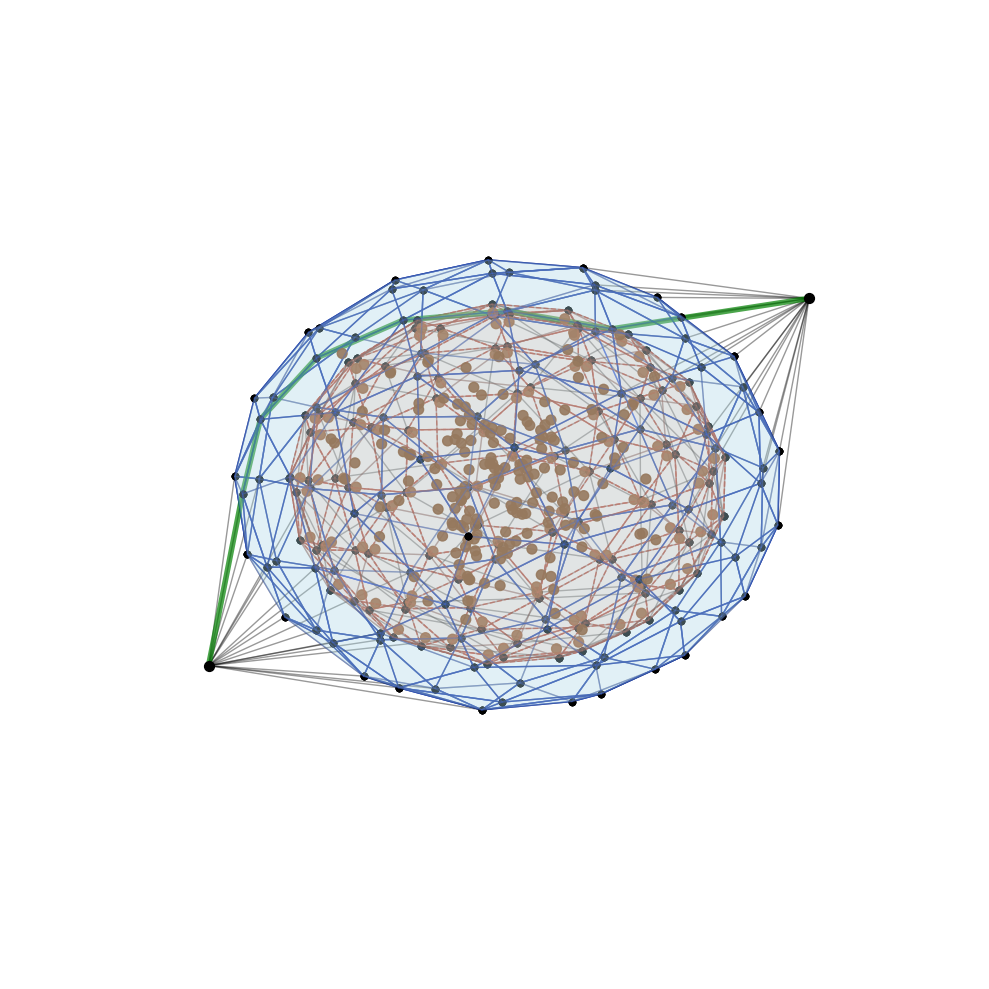

In [3]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import LineString
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Generate random points on a sphere for the outer polytope
num_points = 100
phi = np.pi * (3. - np.sqrt(5.))  # golden angle in radians

y = np.linspace(1 - 1 / num_points, 1 / num_points - 1, num_points)
radius = np.sqrt(1 - y * y)

theta = phi * np.arange(num_points)

x = np.cos(theta) * radius
z = np.sin(theta) * radius

vertices_outer = np.vstack([x, y, z]).T

# Compute the convex hull for the outer polytope
hull_outer = ConvexHull(vertices_outer)

# Scale down for the inner polytope with 0.2 distance
scale_factor = 0.8
center_outer = np.mean(vertices_outer, axis=0)
vertices_inner = (vertices_outer - center_outer) * scale_factor + center_outer

# Compute the convex hull for the inner polytope
hull_inner = ConvexHull(vertices_inner)

# Initialize the graph
G = nx.Graph()

# Add nodes for the outer and inner vertices
for vertex in vertices_outer:
    G.add_node(tuple(vertex))
for vertex in vertices_inner:
    G.add_node(tuple(vertex))

# Function to add edges of the polytope
def add_edges_polytope(graph, vertices, max_distance=np.inf):
    num_vertices = len(vertices)
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            u, v = tuple(vertices[i]), tuple(vertices[j])
            distance = np.linalg.norm(vertices[i] - vertices[j])
            if distance <= max_distance:
                graph.add_edge(u, v, weight=distance)

# Add edges for the outer and inner polytopes with a distance threshold
add_edges_polytope(G, vertices_outer, max_distance=0.5)
add_edges_polytope(G, vertices_inner, max_distance=0.5)

# Define source and end points
source = (-0.8, -0.8, -0.8)
end = (0.8, 0.8, 0.8)

# Add source and end points as nodes
G.add_node(source)
G.add_node(end)

# Function to add edges from a point to polytope vertices with more connections
def add_edges_without_intersection(graph, point, vertices, hull, max_connections=None, max_distance=np.inf):
    distances = []
    for vertex in vertices:
        distance = np.linalg.norm(np.array(point) - np.array(vertex))
        distances.append((distance, vertex))
    
    # Sort by distance and limit the number of connections if max_connections is set
    distances.sort()
    if max_connections is not None:
        distances = distances[:max_connections]

    for distance, vertex in distances:
        if distance <= max_distance:
            weight = LineString([point, vertex]).length
            graph.add_edge(point, tuple(vertex), weight=weight)

# Add more edges for source and end points
add_edges_without_intersection(G, source, vertices_outer, hull_outer, max_connections=20)
add_edges_without_intersection(G, end, vertices_outer, hull_outer, max_connections=20)

# Define heuristic function for A* (Euclidean distance)
def heuristic(u, v):
    return np.linalg.norm(np.array(u) - np.array(v))

# Find the shortest path using A* algorithm
try:
    path = nx.astar_path(G, source, end, heuristic=heuristic, weight='weight')
    print("\nShortest path found by A* algorithm:")
    print(path)
except nx.NetworkXNoPath:
    print("\nNo path found from source to end.")

# Generate random rock-like points within the inner polytope
num_rock_points = 170
rock_points = []
while len(rock_points) < num_rock_points:
    point = np.random.normal(loc=np.mean(vertices_inner, axis=0), scale=scale_factor/3, size=3)
    if np.all(np.min(vertices_inner, axis=0) <= point) and np.all(point <= np.max(vertices_inner, axis=0)):
        rock_points.append(point)

rock_points = np.array(rock_points)

# Save rock points inside inner polytope to a file
with open('rock.txt', 'w') as f:
    for point in rock_points:
        f.write(f"{point[0]}, {point[1]}, {point[2]}\n")

# Calculate points 0.1 units inside the inner polytope
distance_inside = 0.04
points_inside_inner_nodes = []
for vertex in vertices_inner:
    direction_to_center = center_outer - vertex
    direction_normalized = direction_to_center / np.linalg.norm(direction_to_center)
    new_point = vertex + distance_inside * direction_normalized
    points_inside_inner_nodes.append(new_point)

# Convert to a NumPy array for easier manipulation
points_inside_inner_nodes = np.array(points_inside_inner_nodes)

# Add these new points as nodes in the graph
for point in points_inside_inner_nodes:
    G.add_node(tuple(point))

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Function to plot the polytope
def plot_polytope(ax, vertices, hull, face_color, edge_color, alpha, linestyle='-'):
    for simplex in hull.simplices:
        ax.plot(vertices[simplex, 0], vertices[simplex, 1], vertices[simplex, 2], color=edge_color, linestyle=linestyle, linewidth=1)
    
    faces = [
        [vertices[simplex[i]] for i in range(len(simplex))]
        for simplex in hull.simplices
    ]
    poly3d = Poly3DCollection(faces, alpha=alpha, facecolor=face_color, edgecolor=edge_color)
    ax.add_collection3d(poly3d)

# Plot the outer polytope
plot_polytope(ax, vertices_outer, hull_outer, '#ADD8E6', '#4169E1', 0.2)

# Plot the inner polytope
plot_polytope(ax, vertices_inner, hull_inner, '#FFA07A', '#FF6347', 0.1, linestyle='--')

# Plot the rock-like points inside the inner polytope
ax.scatter(rock_points[:, 0], rock_points[:, 1], rock_points[:, 2], color='#8B4513', s=50, alpha=0.9)

# Plot the points 0.1 units inside the inner vertices with the same color as rock points
ax.scatter(points_inside_inner_nodes[:, 0], points_inside_inner_nodes[:, 1], points_inside_inner_nodes[:, 2], color='#8B4513', s=50, alpha=0.9)

# Plot the source and end points
ax.scatter(*source, color='black', s=50)
ax.scatter(*end, color='black', s=50)

# Plot edges, nodes, and shortest path
for edge in G.edges:
    x_vals = [edge[0][0], edge[1][0]]
    y_vals = [edge[0][1], edge[1][1]]
    z_vals = [edge[0][2], edge[1][2]]
    color = 'black'  # Default color for edges
   
    if edge in G.edges:
        ax.plot(x_vals, y_vals, z_vals, color=color, alpha=0.4, linewidth=1)
        for node in edge:
            ax.scatter(*node, color=color, s=20, alpha=0.9)  # Ensure nodes have same color as edges

# Plot the shortest path
if 'path' in locals():
    path_edges = list(zip(path, path[1:]))
    for edge in path_edges:
        x_vals = [edge[0][0], edge[1][0]]
        y_vals = [edge[0][1], edge[1][1]]
        z_vals = [edge[0][2], edge[1][2]]
        ax.plot(x_vals, y_vals, z_vals, color='green', linewidth=4, alpha=0.7)

# Customize the plot
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Remove axis ticks and labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_axis_off()  # Turn off the axis

# Adjust the layout
plt.tight_layout()

plt.show()
